# Native Contact Analysis for Apo Systems
## Project: Exploring the disruption of SARS-CoV-2 RBD binding to hACE2
### Code adapted from MDTraj: https://mdtraj.org/1.9.3/examples/native-contact.html
### Additional code written by Camryn Carter

All inputs are specific to my SARS-CoV-2 RBD inhibitors project.

In [7]:
#interface native contact analysis
## Used the original code from Best et al., but edited it so that it only applied to native contacts between the interface

import numpy as np
import mdtraj as md
from itertools import combinations

def test_best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    #Create a list of atoms based on the specific chain in the PDB. There are two chains 0 (RBD) and 1 (hACE2).
    chain0 = native.topology.select("chainid 0")
    chain1 = native.topology.select("chainid 1")
    
    #get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    
    ###Our addition to the code begins here###
    #create a list of heavy atoms in chain 0
    heavy_list0 = []
    
    for atom_index in chain0:
        if atom_index in heavy:
            heavy_list0.append(atom_index)
    
    #create a list of heavy atoms in chain 1
    heavy_list1 = []
    
    for atom_index in chain1:
        if atom_index in heavy:
            heavy_list1.append(atom_index)
    
    #First create a list of list of all possible pairs of atoms between the two chains 
    heavyPairs_list = []
    
    for x in heavy_list0:
        for y in heavy_list1:
            temp =[]
            temp.append(x)
            temp.append(y)
            heavyPairs_list.append(temp)

    #Create a numpy array using the list previously created between both of the chains        
    heavyPairs_np = np.array(heavyPairs_list)
    #print(heavyPairs_np.shape)
    
    ###Our addition to the code ends here###
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavyPairs_np)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavyPairs_np[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q2 = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q2  

In [ ]:
#need to load in my nc files for traj
traj = md.load_netcdf('6lzg_COVID_Spike_hACE2_Glycans_Glycam06j_Zn_300ns_all_Seeds_imaged.nc', '6lzg_COVID_Spike_hACE2_w_glycans_Glycam06j_Zn.prmtop')
# to load a pdb
pdb = md.load_pdb('6lzg_COVID_Spike_hACE2_w_glycans_Glycam06j_Zn_0ns.pdb')
#This is the reference structure
native = pdb

In [8]:
#Running the native contact analysis code
q_test = test_best_hummer_q(traj, native)
print(q_test)

Number of native contacts 299
[0.9916167  0.99114    0.98779    ... 0.9363912  0.94674844 0.94546276]


numpy.ndarray

In [7]:
#Figuring out which frames had low fraction of native contacts
#Looking at fractions less than 0.85
for i in range(q_test.size):
    if q_test[i] < 0.85:
        print(i, "and", q_test[i])
q_test.mean()

6493 and 0.82193005
6494 and 0.83099884
6495 and 0.83235365
6496 and 0.8252251
6497 and 0.8035624
6498 and 0.84286875
6499 and 0.83900505
6500 and 0.79290235
6501 and 0.8104927
6502 and 0.8330721
6503 and 0.8264107
6504 and 0.81273466
6505 and 0.795235
6506 and 0.8304729
6507 and 0.8278089
6508 and 0.83639514
6509 and 0.83543557
6510 and 0.83070904
6511 and 0.83965
6512 and 0.8441953
6557 and 0.8351045
6570 and 0.8388143
6621 and 0.84208304
6624 and 0.8462383
6625 and 0.84610516
6626 and 0.83900976
6628 and 0.83931637
6629 and 0.8292737
6630 and 0.8253766
6631 and 0.7916879
6632 and 0.79892415
6633 and 0.8444222
6634 and 0.8163239
6635 and 0.82408476
6637 and 0.8359228
6638 and 0.8404351
6640 and 0.81969035
6646 and 0.8498385
6649 and 0.8398513
6656 and 0.8364671
6657 and 0.8412638
6658 and 0.823998
6659 and 0.8351764
6661 and 0.83987635
6662 and 0.84537816
6663 and 0.84775394
6667 and 0.8334024
6673 and 0.84645826
6675 and 0.8219163
6676 and 0.8156668
6677 and 0.7905438
6678 and 0.780

0.93863386

In [9]:
#Printing the average and standard deviation of the fraction of native contacts 
print(q_test.mean())
print(q_test.std())

0.93863386
0.030924791


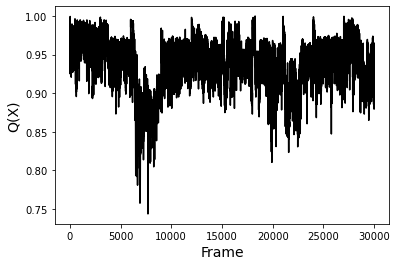

In [9]:
# plot the fraction of native contacts 
import matplotlib.pyplot as plt
plt.plot(q_test, color="black")
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
#plt.title('Native Contact Analysis in the Interface')
#plt.show()
plt.savefig("native_contact_binding_site_allSeeds_wouttitle.jpg", dpi = 300)